In [10]:
# Cell 1: Install required packages
!pip install pandas bravado rdkit-pypi nglview==3.0.8 ipywidgets biopandas
!pip install git+https://github.com/volkamerlab/opencadd.git

  Cloning https://github.com/volkamerlab/opencadd.git to /tmp/pip-req-build-wtp2rzbf
  Running command git clone --filter=blob:none --quiet https://github.com/volkamerlab/opencadd.git /tmp/pip-req-build-wtp2rzbf
  Resolved https://github.com/volkamerlab/opencadd.git to commit c76e87c4fdcb822dfc025e6cb87c34c9e17505d2
  Preparing metadata (setup.py) ... done


In [11]:
# Cell 2: Import necessary libraries
import logging
import pandas as pd
import nglview as nv
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from bravado.client import SwaggerClient
from IPython.display import display, Markdown
import opencadd


In [12]:
# Cell 3: Set up logging and pandas display options
logging.getLogger("numexpr").setLevel(logging.ERROR)
pd.set_option("display.max_columns", 50)

In [17]:
# Cell 4: Define kinase of interest
species = "Human"
kinase_name = "BACE1"
ligand_expo_id = "5SE"  # Example BACE1 inhibitor (verubecestat)

In [18]:
# Cell 5: Generate KLIFS Python client
KLIFS_API_DEFINITIONS = "https://klifs.net/swagger/swagger.json"
KLIFS_CLIENT = SwaggerClient.from_url(KLIFS_API_DEFINITIONS, config={"validate_responses": False})

In [19]:
# Cell 6: Get available kinase groups
kinase_groups = KLIFS_CLIENT.Information.get_kinase_groups().response().result
print("Available kinase groups:", kinase_groups)

Available kinase groups: ['AGC', 'CAMK', 'CK1', 'CMGC', 'Other', 'STE', 'TK', 'TKL']


In [20]:
# Cell 7: Get available kinase families for each group
for group in kinase_groups:
    families = KLIFS_CLIENT.Information.get_kinase_families(kinase_group=group).response().result
    print(f"\nKinase families in {group}:")
    print(families)


Kinase families in AGC:
['AKT', 'Akt', 'DMPK', 'GRK', 'MAST', 'NDR', 'PDK1', 'PKA', 'PKC', 'PKG', 'PKN', 'RSK', 'RSKL', 'RSKR', 'SGK', 'YANK']

Kinase families in CAMK:
['CAMK-Unique', 'CAMK1', 'CAMK2', 'CAMKL', 'CASK', 'DAPK', 'DCAMKL', 'MAPKAPK', 'MLCK', 'PHK', 'PIM', 'PKD', 'PSK', 'RAD53', 'RSKb', 'SgK495', 'TSSK', 'Trbl', 'Trio']

Kinase families in CK1:
['CK1', 'TTBK', 'VRK']

Kinase families in CMGC:
['CDK', 'CDKL', 'CK2', 'CLK', 'DYRK', 'GSK', 'MAPK', 'RCK', 'SRPK']

Kinase families in Other:
['AUR', 'Aur', 'BUB', 'Bud32', 'CAMKK', 'CDC7', 'CK2', 'Haspin', 'IKK', 'IRE', 'KIS', 'MOS', 'NAK', 'NEK', 'NKF1', 'NKF2', 'NKF3', 'NKF4', 'NKF5', 'NRBP', 'Other-Unique', 'PAN3', 'PEK', 'PLK', 'SCY1', 'SgK071', 'SgK493', 'SgK496', 'Slob', 'TBCK', 'TLK', 'TOPK', 'TTK', 'ULK', 'VPS15', 'WEE', 'WNK', 'Wnk']

Kinase families in STE:
['STE-Unique', 'STE11', 'STE20', 'STE7']

Kinase families in TK:
['ALK', 'Abl', 'Ack', 'Alk', 'Axl', 'CCK4', 'Csk', 'DDR', 'EGFR', 'Eph', 'FAK', 'FGFR', 'Fer', 'In

In [22]:
# Cell 1: Import necessary libraries
import pandas as pd
import nglview as nv
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from IPython.display import display, Markdown
from opencadd.databases.klifs import setup_remote


In [23]:
# Cell 2: Set up opencadd remote session
session = setup_remote()

In [24]:
# Cell 3: Define kinase of interest
species = "Human"
kinase_name = "BACE1"
ligand_expo_id = "5SE"  # Example BACE1 inhibitor (verubecestat)

In [26]:
# Cell 4: Inspect and get KLIFS ID for BACE1
kinases = session.kinases.all_kinases()
print("Columns in the kinases DataFrame:")
print(kinases.columns)
print("\nFirst few rows of the kinases DataFrame:")
display(kinases.head())

Columns in the kinases DataFrame:
Index(['kinase.klifs_id', 'kinase.klifs_name', 'kinase.full_name',
       'kinase.gene_name', 'kinase.uniprot', 'species.klifs'],
      dtype='object')

First few rows of the kinases DataFrame:


kinase.klifs_id kinase.klifs_name            kinase.full_name  \
0              529                A6                           0   
1              530               A6r                           0   
2              815           MarkmE3  RIKEN cDNA 4921509C19 gene   
3              814           MarkmE2  RIKEN cDNA 4921509C19 gene   
4              813           MarkmE1  RIKEN cDNA 4921509C19 gene   

  kinase.gene_name kinase.uniprot species.klifs  
0                               0         Mouse  
1                               0         Mouse  
2    4921509C19Rik         Q8C0X8         Mouse  
3    4921509C19Rik         Q8C0X8         Mouse  
4    4921509C19Rik         Q8C0X8         Mouse

In [28]:
# Cell 4: Inspect and get KLIFS ID for BACE1
kinases = session.kinases.all_kinases()
print("Columns in the kinases DataFrame:")
print(kinases.columns)
print("\nFirst few rows of the kinases DataFrame:")
display(kinases.head())

# Now let's try to find BACE1
bace1_info = kinases[kinases['kinase.full_name'].str.contains(kinase_name, case=False, na=False)]

if not bace1_info.empty:
    kinase_klifs_id = bace1_info['kinase.klifs_id'].values[0]
    kinase_full_name = bace1_info['kinase.full_name'].values[0]
    kinase_gene_name = bace1_info['kinase.gene_name'].values[0]
    print(f"\nBACE1 KLIFS ID: {kinase_klifs_id}")
    print(f"BACE1 Full Name: {kinase_full_name}")
    print(f"BACE1 Gene Name: {kinase_gene_name}")
else:
    print("\nBACE1 not found in KLIFS database")
    # If BACE1 is not found, let's list available kinases
    print("\nAvailable kinases (first 20):")
    print(kinases['kinase.full_name'].head(20).to_list())

Columns in the kinases DataFrame:
Index(['kinase.klifs_id', 'kinase.klifs_name', 'kinase.full_name',
       'kinase.gene_name', 'kinase.uniprot', 'species.klifs'],
      dtype='object')

First few rows of the kinases DataFrame:


kinase.klifs_id kinase.klifs_name            kinase.full_name  \
0              529                A6                           0   
1              530               A6r                           0   
2              815           MarkmE3  RIKEN cDNA 4921509C19 gene   
3              814           MarkmE2  RIKEN cDNA 4921509C19 gene   
4              813           MarkmE1  RIKEN cDNA 4921509C19 gene   

  kinase.gene_name kinase.uniprot species.klifs  
0                               0         Mouse  
1                               0         Mouse  
2    4921509C19Rik         Q8C0X8         Mouse  
3    4921509C19Rik         Q8C0X8         Mouse  
4    4921509C19Rik         Q8C0X8         Mouse


BACE1 not found in KLIFS database

Available kinases (first 20):
['0', '0', 'RIKEN cDNA 4921509C19 gene', 'RIKEN cDNA 4921509C19 gene', 'RIKEN cDNA 4921509C19 gene', 'AP2 associated kinase 1', 'AP2 associated kinase 1', 'apoptosis-associated tyrosine kinase', 'apoptosis-associated tyrosine kinase', 'c-abl oncogene 1, non-receptor tyrosine kinase', 'ABL proto-oncogene 1, non-receptor tyrosine kinase', 'v-abl Abelson murine leukemia viral oncogene 2 (arg, Abelson-related gene)', 'ABL proto-oncogene 2, non-receptor tyrosine kinase', 'activin A receptor, type 1', 'activin A receptor type I', 'activin A receptor, type 1B', 'activin A receptor type IB', 'activin A receptor, type IC', 'activin A receptor type IC', 'activin receptor IIA']


In [30]:
# Cell 3: Define kinase of interest
species = "Human"
kinase_name = "AATK"

In [31]:
# Cell 4: Get KLIFS ID for AATK
kinases = session.kinases.all_kinases()
aatk_info = kinases[kinases['kinase.full_name'].str.contains("apoptosis-associated tyrosine kinase", case=False, na=False)]

if not aatk_info.empty:
    kinase_klifs_id = aatk_info['kinase.klifs_id'].values[0]
    kinase_full_name = aatk_info['kinase.full_name'].values[0]
    kinase_gene_name = aatk_info['kinase.gene_name'].values[0]
    print(f"\nAATK KLIFS ID: {kinase_klifs_id}")
    print(f"AATK Full Name: {kinase_full_name}")
    print(f"AATK Gene Name: {kinase_gene_name}")
else:
    print("\nAATK not found in KLIFS database")
    raise ValueError("AATK not found. Cannot continue analysis.")


AATK KLIFS ID: 760
AATK Full Name: apoptosis-associated tyrosine kinase
AATK Gene Name: Aatk


In [34]:
# Cell 3: Get all kinases and filter for potentially relevant ones
kinases = session.kinases.all_kinases()
print(f"Total number of kinases in the database: {len(kinases)}")
# List of keywords related to neurological processes
neuro_keywords = ['neuro', 'brain', 'synap', 'axon', 'dendrite', 'cogniti', 'memory', 'learning', 'apoptosis']

# Filter kinases based on keywords
neuro_kinases = kinases[kinases['kinase.full_name'].str.contains('|'.join(neuro_keywords), case=False, na=False)]

print(f"\nNumber of potentially relevant kinases: {len(neuro_kinases)}")
print("\nTop 10 potentially relevant kinases:")
display(neuro_kinases[['kinase.klifs_id', 'kinase.full_name', 'kinase.gene_name']].head(10))


Total number of kinases in the database: 1127

Number of potentially relevant kinases: 9

Top 10 potentially relevant kinases:


kinase.klifs_id                                  kinase.full_name  \
7                760              apoptosis-associated tyrosine kinase   
8                443              apoptosis-associated tyrosine kinase   
649             1026    neurotrophic tyrosine kinase, receptor, type 1   
650              480    neurotrophic tyrosine kinase, receptor, type 1   
651             1027    neurotrophic tyrosine kinase, receptor, type 2   
652              481    neurotrophic tyrosine kinase, receptor, type 2   
653             1028    neurotrophic tyrosine kinase, receptor, type 3   
654              482    neurotrophic tyrosine kinase, receptor, type 3   
958              656  serine/threonine kinase 17b (apoptosis-inducing)   

    kinase.gene_name  
7               Aatk  
8               AATK  
649            Ntrk1  
650            NTRK1  
651            Ntrk2  
652            NTRK2  
653            Ntrk3  
654            NTRK3  
958           Stk17b

In [35]:
# Cell 3: Define kinases of interest
kinases_of_interest = [
    {"id": 443, "name": "AATK", "full_name": "apoptosis-associated tyrosine kinase"},
    {"id": 480, "name": "NTRK1", "full_name": "neurotrophic tyrosine kinase, receptor, type 1"},
    {"id": 481, "name": "NTRK2", "full_name": "neurotrophic tyrosine kinase, receptor, type 2"},
    {"id": 482, "name": "NTRK3", "full_name": "neurotrophic tyrosine kinase, receptor, type 3"},
    {"id": 656, "name": "STK17B", "full_name": "serine/threonine kinase 17b (apoptosis-inducing)"}
]

In [38]:
# Cell 4: Function to analyze a specific kinase
def analyze_kinase(kinase_klifs_id, kinase_name, kinase_full_name):
    print(f"\nAnalyzing {kinase_name} ({kinase_full_name})")
    
    try:
        # Get structures for the kinase
        structures = session.structures.by_kinase_klifs_id(kinase_klifs_id)
        num_structures = len(structures)
        print(f"Number of structures: {num_structures}")
        
        # Get ligands
        ligands = session.ligands.by_kinase_klifs_id(kinase_klifs_id)
        num_ligands = len(ligands)
        print(f"Number of known ligands: {num_ligands}")
        
        # Get bioactivities
        if not ligands.empty:
            ligand_expo_ids = ligands['ligand.expo_id'].tolist()[:10]  # Limit to first 10 ligands
            bioactivities = session.bioactivities.by_ligand_expo_id(ligand_expo_ids)
            num_bioactivities = len(bioactivities)
            print(f"Number of bioactivity data points: {num_bioactivities}")
        else:
            num_bioactivities = 0
        
        return {
            "Kinase": kinase_name,
            "Full Name": kinase_full_name,
            "Structures": num_structures,
            "Ligands": num_ligands,
            "Bioactivities": num_bioactivities
        }
    
    except Exception as e:
        print(f"Error analyzing kinase: {str(e)}")
        return {
            "Kinase": kinase_name,
            "Full Name": kinase_full_name,
            "Structures": 0,
            "Ligands": 0,
            "Bioactivities": 0
        }


In [39]:
# Cell 5: Analyze kinases of interest
results = []
for kinase in kinases_of_interest:
    result = analyze_kinase(kinase['id'], kinase['name'], kinase['full_name'])
    results.append(result)


Analyzing AATK (apoptosis-associated tyrosine kinase)
Error analyzing kinase: Expected type to be dict for value [400, 'KLIFS error: An unknown kinase ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.

Analyzing NTRK1 (neurotrophic tyrosine kinase, receptor, type 1)
Number of structures: 96


/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:143: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["structure.alternate_model"].replace("", "-", inplace=True)
/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will n

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

Number of known ligands: 50


/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["ligand.expo_id"].replace(0, "-", inplace=True)
/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work be

Processing...:   0%|          | 0/10 [00:00<?, ?it/s]

There was (were) 2/10 failed request(s).
Show error messages (up to 5 messages only):
Error for 4F6: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for YMX: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


Number of bioactivity data points: 56

Analyzing NTRK2 (neurotrophic tyrosine kinase, receptor, type 2)
Number of structures: 4


/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:143: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["structure.alternate_model"].replace("", "-", inplace=True)
/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will n

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

Number of known ligands: 3


/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["ligand.expo_id"].replace(0, "-", inplace=True)
/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work be

Processing...:   0%|          | 0/3 [00:00<?, ?it/s]

There was (were) 1/3 failed request(s).
Show error messages (up to 5 messages only):
Error for LTI: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


Number of bioactivity data points: 105

Analyzing NTRK3 (neurotrophic tyrosine kinase, receptor, type 3)
Number of structures: 8


/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:143: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["structure.alternate_model"].replace("", "-", inplace=True)
/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will n

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

Number of known ligands: 4


/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["ligand.expo_id"].replace(0, "-", inplace=True)
/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work be

Processing...:   0%|          | 0/4 [00:00<?, ?it/s]

There was (were) 2/4 failed request(s).
Show error messages (up to 5 messages only):
Error for DZC: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for DZ6: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


Number of bioactivity data points: 57

Analyzing STK17B (serine/threonine kinase 17b (apoptosis-inducing))
Error analyzing kinase: Expected type to be dict for value [400, 'KLIFS error: An unknown kinase ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


In [40]:
# Cell 6: Display results and recommend kinase for further analysis
results_df = pd.DataFrame(results)
display(results_df.sort_values(by=['Structures', 'Ligands', 'Bioactivities'], ascending=False))

recommended_kinase = results_df.loc[results_df['Structures'] > 0].iloc[0]
print(f"\nRecommended kinase for further analysis: {recommended_kinase['Kinase']} ({recommended_kinase['Full Name']})")
print(f"Number of structures: {recommended_kinase['Structures']}")
print(f"Number of known ligands: {recommended_kinase['Ligands']}")
print(f"Number of bioactivity data points: {recommended_kinase['Bioactivities']}")

Kinase                                         Full Name  Structures  \
1   NTRK1    neurotrophic tyrosine kinase, receptor, type 1          96   
3   NTRK3    neurotrophic tyrosine kinase, receptor, type 3           8   
2   NTRK2    neurotrophic tyrosine kinase, receptor, type 2           4   
0    AATK              apoptosis-associated tyrosine kinase           0   
4  STK17B  serine/threonine kinase 17b (apoptosis-inducing)           0   

   Ligands  Bioactivities  
1       50             56  
3        4             57  
2        3            105  
0        0              0  
4        0              0


Recommended kinase for further analysis: NTRK1 (neurotrophic tyrosine kinase, receptor, type 1)
Number of structures: 96
Number of known ligands: 50
Number of bioactivity data points: 56


In [41]:
# Cell 7: Function to perform detailed analysis on the recommended kinase
def detailed_kinase_analysis(kinase_klifs_id, kinase_name, kinase_full_name):
    print(f"\nDetailed analysis of {kinase_name} ({kinase_full_name})")
    
    # Get structures
    structures = session.structures.by_kinase_klifs_id(kinase_klifs_id)
    print(f"Number of structures: {len(structures)}")
    
    if len(structures) > 0:
        # Get a sample structure
        sample_structure_id = structures.iloc[0]['structure.klifs_id']
        structure_text = session.coordinates.to_text(sample_structure_id, "complex", "pdb")
        
        # Visualize the structure
        v = nv.NGLWidget()
        v.add_component(structure_text, ext="pdb")
        display(v)
        
        # Get ligands
        ligands = session.ligands.by_kinase_klifs_id(kinase_klifs_id)
        print(f"\nNumber of known ligands: {len(ligands)}")
        if not ligands.empty:
            print("\nSample of ligands:")
            display(ligands.head())
            
            # Visualize some ligands
            sample_smiles = ligands['ligand.smiles'].head(5).tolist()
            img = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sample_smiles], molsPerRow=5, subImgSize=(200,200))
            display(img)
            
            # Get bioactivities
            ligand_expo_ids = ligands['ligand.expo_id'].tolist()[:10]  # Limit to first 10 ligands
            bioactivities = session.bioactivities.by_ligand_expo_id(ligand_expo_ids)
            print(f"\nNumber of bioactivity data points: {len(bioactivities)}")
            if not bioactivities.empty:
                print("\nSample of bioactivity data:")
                display(bioactivities.head())


Detailed analysis of NTRK1 (neurotrophic tyrosine kinase, receptor, type 1)


/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:143: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["structure.alternate_model"].replace("", "-", inplace=True)
/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will n

Number of structures: 96


NGLWidget()

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]


Number of known ligands: 50

Sample of ligands:


/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["ligand.expo_id"].replace(0, "-", inplace=True)
/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work be

ligand.klifs_id ligand.expo_id  \
0             1096            31X   
1             1097            V4Z   
2             1098            31W   
3             1099            4EK   
4             1100            31Y   

                                         ligand.name  \
0  4-(naphthalen-1-yl)-1-[(5-phenyl-1,2,4-oxadiaz...   
1  5-chloranyl-N2-[(1S)-1-(5-fluoranylpyridin-2-y...   
2  1-cyclopropyl-1-[3-(1,3-thiazol-2-yl)benzyl]-3...   
3  6-[(2R)-2-(3-fluorophenyl)pyrrolidin-1-yl]-3-(...   
4  N~4~-[4-(morpholin-4-yl)phenyl]-N~6~-(pyridin-...   

                                       ligand.smiles  \
0  O=C(O)C=1N(c2c(c(ncc2)c3c4c(ccc3)cccc4)C1)CC5=...   
1  Clc1c(nc(nc1)N[C@H](c2ncc(F)cc2)C)NC=3NN=C(OC(...   
2  S1C(=NC=C1)c2cc(ccc2)CN(C(=O)Nc3ccc(OC(F)(F)F)...   
3  Fc1cc(ccc1)[C@@H]2N(C3=NN4C(=NC=C4c5ncccc5)C=C...   
4    O1CCN(c2ccc(Nc3ncnc4c3nc(NCc5cnccc5)cc4)cc2)CC1   

               ligand.inchikey  kinase.klifs_id (query)  
0  BUVASZPZZZNEAY-UHFFFAOYSA-N                      480  
1  LBVKEEFIPBQIMD-JTQLQIEISA-N                      480  
2  VXBUABPTAFKXED-UHFFFAOYSA-N                      480  
3  RKERQEKFTWWCEY-GOSISDBHSA-N                      480  
4  DCLOYUQZPOKYDM-UHFFFAOYSA-N                      480

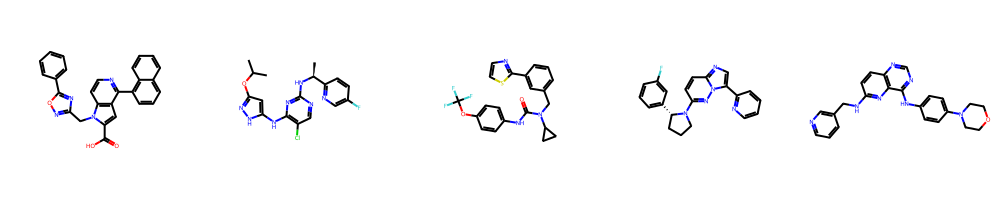

Processing...:   0%|          | 0/10 [00:00<?, ?it/s]

There was (were) 2/10 failed request(s).
Show error messages (up to 5 messages only):
Error for 4F6: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for YMX: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.



Number of bioactivity data points: 56

Sample of bioactivity data:


kinase.pref_name kinase.uniprot kinase.chembl_id  \
0  Nerve growth factor receptor Trk-A         P04629       CHEMBL2815   
1  Nerve growth factor receptor Trk-A         P04629       CHEMBL2815   
2                                HERG         Q12809        CHEMBL240   
3  Nerve growth factor receptor Trk-A         P04629       CHEMBL2815   
4  Nerve growth factor receptor Trk-A         P04629       CHEMBL2815   

  ligand.chembl_id ligand.bioactivity_standard_type  \
0    CHEMBL3298162                             IC50   
1    CHEMBL3298162                               Kd   
2     CHEMBL457614                             IC50   
3     CHEMBL457614                             EC50   
4     CHEMBL457614                             IC50   

  ligand.bioactivity_standard_relation  ligand.bioactivity_standard_value  \
0                                    =                            2300.00   
1                                    =                               7.90   
2                                    =                            5200.00   
3                                    =                               1.00   
4                                    =                               0.26   

  ligand.bioactivity_standard_units  ligand.bioactivity_pchembl_value  \
0                                nM                              5.64   
1                                nM                              8.10   
2                                nM                              5.28   
3                                nM                              9.00   
4                                nM                              9.59   

  species.chembl ligand.expo_id (query)  
0   Homo sapiens                    31X  
1   Homo sapiens                    31X  
2   Homo sapiens                    V4Z  
3   Homo sapiens                    V4Z  
4   Homo sapiens                    V4Z

In [42]:
# Cell 8: Perform detailed analysis on the recommended kinase
recommended_kinase_info = next(k for k in kinases_of_interest if k['name'] == recommended_kinase['Kinase'])
detailed_kinase_analysis(recommended_kinase_info['id'], recommended_kinase_info['name'], recommended_kinase_info['full_name'])

In [47]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Crippen, Lipinski
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from biopandas.pdb import PandasPdb
from scipy.spatial.distance import cdist
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming we have already set up the KLIFS session and have the necessary data
# If not, uncomment and run these lines:
# from opencadd.databases.klifs import setup_remote
# session = setup_remote()
# kinase_klifs_id = 480  # NTRK1

# 1. Ligand Structure Analysis
def analyze_ligands(ligands_df, bioactivities_df):
    # Merge ligand and bioactivity data
    merged_data = pd.merge(ligands_df, bioactivities_df, left_on='ligand.expo_id', right_on='ligand.expo_id (query)')
    
    # Convert SMILES to RDKit molecules
    molecules = [Chem.MolFromSmiles(smiles) for smiles in merged_data['ligand.smiles']]
    
    # Calculate molecular properties
    properties = []
    for mol in molecules:
        if mol is not None:
            props = {
                'MW': Descriptors.ExactMolWt(mol),
                'LogP': Crippen.MolLogP(mol),
                'HBA': Lipinski.NumHAcceptors(mol),
                'HBD': Lipinski.NumHDonors(mol),
                'TPSA': Descriptors.TPSA(mol),
                'RotBonds': Lipinski.NumRotatableBonds(mol)
            }
        else:
            props = {
                'MW': None, 'LogP': None, 'HBA': None,
                'HBD': None, 'TPSA': None, 'RotBonds': None
            }
        properties.append(props)
    
    properties_df = pd.DataFrame(properties)
    merged_data = pd.concat([merged_data, properties_df], axis=1)
    
    # Sort by potency (assuming lower IC50 is better)
    merged_data = merged_data.sort_values('ligand.bioactivity_standard_value')
    
    print("Top 5 most potent compounds:")
    display(merged_data[['ligand.name', 'ligand.bioactivity_standard_value', 'MW', 'LogP', 'HBA', 'HBD', 'TPSA', 'RotBonds']].head())
    
    # Visualize top 5 compounds
    top_mols = [Chem.MolFromSmiles(smiles) for smiles in merged_data['ligand.smiles'].head()]
    img = Draw.MolsToGridImage(top_mols, molsPerRow=3, subImgSize=(300,300), legends=list(merged_data['ligand.name'].head()))
    display(img)
    
    # Analyze property distribution
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, prop in enumerate(['MW', 'LogP', 'HBA', 'HBD', 'TPSA', 'RotBonds']):
        sns.histplot(data=merged_data, x=prop, ax=axes[i], kde=True)
        axes[i].set_title(prop)
    
    plt.tight_layout()
    plt.show()
    
    return merged_data


In [48]:
# 2. Protein-Ligand Interaction Analysis
def analyze_protein_ligand_interactions(structure_klifs_id, session):
    # Fetch protein and ligand coordinates
    protein_text = session.coordinates.to_text(structure_klifs_id, "protein", "pdb")
    ligand_text = session.coordinates.to_text(structure_klifs_id, "ligand", "mol2")
    
    # Parse protein structure
    protein = PandasPdb().read_pdb_from_list(protein_text.split('\n'))
    protein_coords = protein.df['ATOM'][['x_coord', 'y_coord', 'z_coord']].values
    
    # Parse ligand structure
    ligand = Chem.MolFromMol2Block(ligand_text)
    ligand_coords = ligand.GetConformer().GetPositions()
    
    # Calculate distances between protein and ligand atoms
    distances = cdist(protein_coords, ligand_coords)
    
    # Identify close contacts (e.g., < 4 Ã…)
    close_contacts = np.where(distances < 4.0)
    
    print(f"Number of close contacts: {len(close_contacts[0])}")
    
    # Analyze the types of interactions (you may need to expand this based on atom types)
    interaction_types = []
    for p_idx, l_idx in zip(close_contacts[0], close_contacts[1]):
        p_atom = protein.df['ATOM'].iloc[p_idx]
        l_atom = ligand.GetAtomWithIdx(l_idx)
        
        if p_atom['atom_name'].strip() in ['N', 'O'] and l_atom.GetSymbol() in ['N', 'O']:
            interaction_types.append('Hydrogen Bond')
        elif p_atom['atom_name'].strip() == 'C' and l_atom.GetSymbol() == 'C':
            interaction_types.append('Hydrophobic')
        else:
            interaction_types.append('Other')
    
    interaction_counts = pd.Series(interaction_types).value_counts()
    print("\nInteraction types:")
    print(interaction_counts)
    
    # Visualize interaction types
    plt.figure(figsize=(8, 6))
    interaction_counts.plot(kind='bar')
    plt.title('Protein-Ligand Interaction Types')
    plt.xlabel('Interaction Type')
    plt.ylabel('Count')
    plt.show()


In [49]:
# 3. Selectivity Profile Analysis
def analyze_selectivity(bioactivities_df, ntrk_ids):
    # Filter bioactivities for NTRKs
    ntrk_bioactivities = bioactivities_df[bioactivities_df['kinase.klifs_id (query)'].isin(ntrk_ids)]
    
    # Pivot the data to compare activities across NTRKs
    pivoted_data = ntrk_bioactivities.pivot(index='ligand.expo_id (query)', 
                                            columns='kinase.pref_name', 
                                            values='ligand.bioactivity_standard_value')
    
    print("Selectivity profile for NTRK inhibitors:")
    display(pivoted_data.head())
    
    # Calculate selectivity ratios (NTRK1 vs NTRK2 and NTRK3)
    pivoted_data['NTRK1_NTRK2_ratio'] = pivoted_data['Nerve growth factor receptor Trk-A'] / pivoted_data['BDNF/NT-3 growth factors receptor']
    pivoted_data['NTRK1_NTRK3_ratio'] = pivoted_data['Nerve growth factor receptor Trk-A'] / pivoted_data['NT-3 growth factor receptor']
    
    print("\nSelectivity ratios (NTRK1 / NTRK2 and NTRK1 / NTRK3):")
    display(pivoted_data[['NTRK1_NTRK2_ratio', 'NTRK1_NTRK3_ratio']].head())
    
    # Visualize selectivity
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=pivoted_data, x='Nerve growth factor receptor Trk-A', y='BDNF/NT-3 growth factors receptor')
    plt.title('NTRK1 vs NTRK2 Activity')
    plt.xlabel('NTRK1 Activity (nM)')
    plt.ylabel('NTRK2 Activity (nM)')
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

In [50]:
# Main analysis pipeline
def main_analysis(session, ntrk1_id):
    # Fetch data
    ligands = session.ligands.by_kinase_klifs_id(ntrk1_id)
    structures = session.structures.by_kinase_klifs_id(ntrk1_id)
    bioactivities = session.bioactivities.by_ligand_expo_id(ligands['ligand.expo_id'].tolist())
    
    # 1. Ligand Structure Analysis
    print("Performing ligand structure analysis...")
    merged_data = analyze_ligands(ligands, bioactivities)
    
    # 2. Protein-Ligand Interaction Analysis
    print("\nPerforming protein-ligand interaction analysis...")
    # Use the first available structure for this example
    sample_structure_id = structures.iloc[0]['structure.klifs_id']
    analyze_protein_ligand_interactions(sample_structure_id, session)
    
    # 3. Selectivity Profile Analysis
    print("\nPerforming selectivity profile analysis...")
    ntrk_ids = [480, 481, 482]  # NTRK1, NTRK2, NTRK3
    analyze_selectivity(bioactivities, ntrk_ids)
    
    print("\nAnalysis complete!")


Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["ligand.expo_id"].replace(0, "-", inplace=True)
/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work be

Processing...:   0%|          | 0/50 [00:00<?, ?it/s]

There was (were) 14/50 failed request(s).
Show error messages (up to 5 messages only):
Error for 4F6: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for YMX: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for 6UK: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for 6UH: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for FQD: Expected type to be dict for value [400, 'KLIFS error: No bioactivities for kinases are available from ChEMBL for this ligand.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> 

Performing ligand structure analysis...
Top 5 most potent compounds:


ligand.name  ligand.bioactivity_standard_value          MW    LogP  \
192  Repotrectinib                               0.01  355.144453  2.5522   
191  Repotrectinib                               0.05  355.144453  2.5522   
196  Repotrectinib                               0.07  355.144453  2.5522   
193  Repotrectinib                               0.10  355.144453  2.5522   
188  Repotrectinib                               0.11  355.144453  2.5522   

     HBA  HBD   TPSA  RotBonds  
192    6    2  80.55         0  
191    6    2  80.55         0  
196    6    2  80.55         0  
193    6    2  80.55         0  
188    6    2  80.55         0

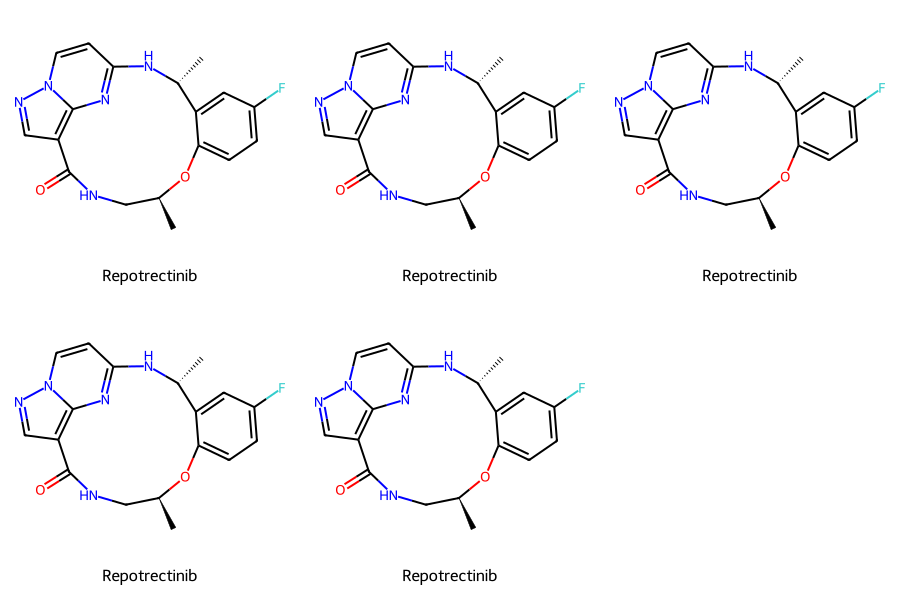

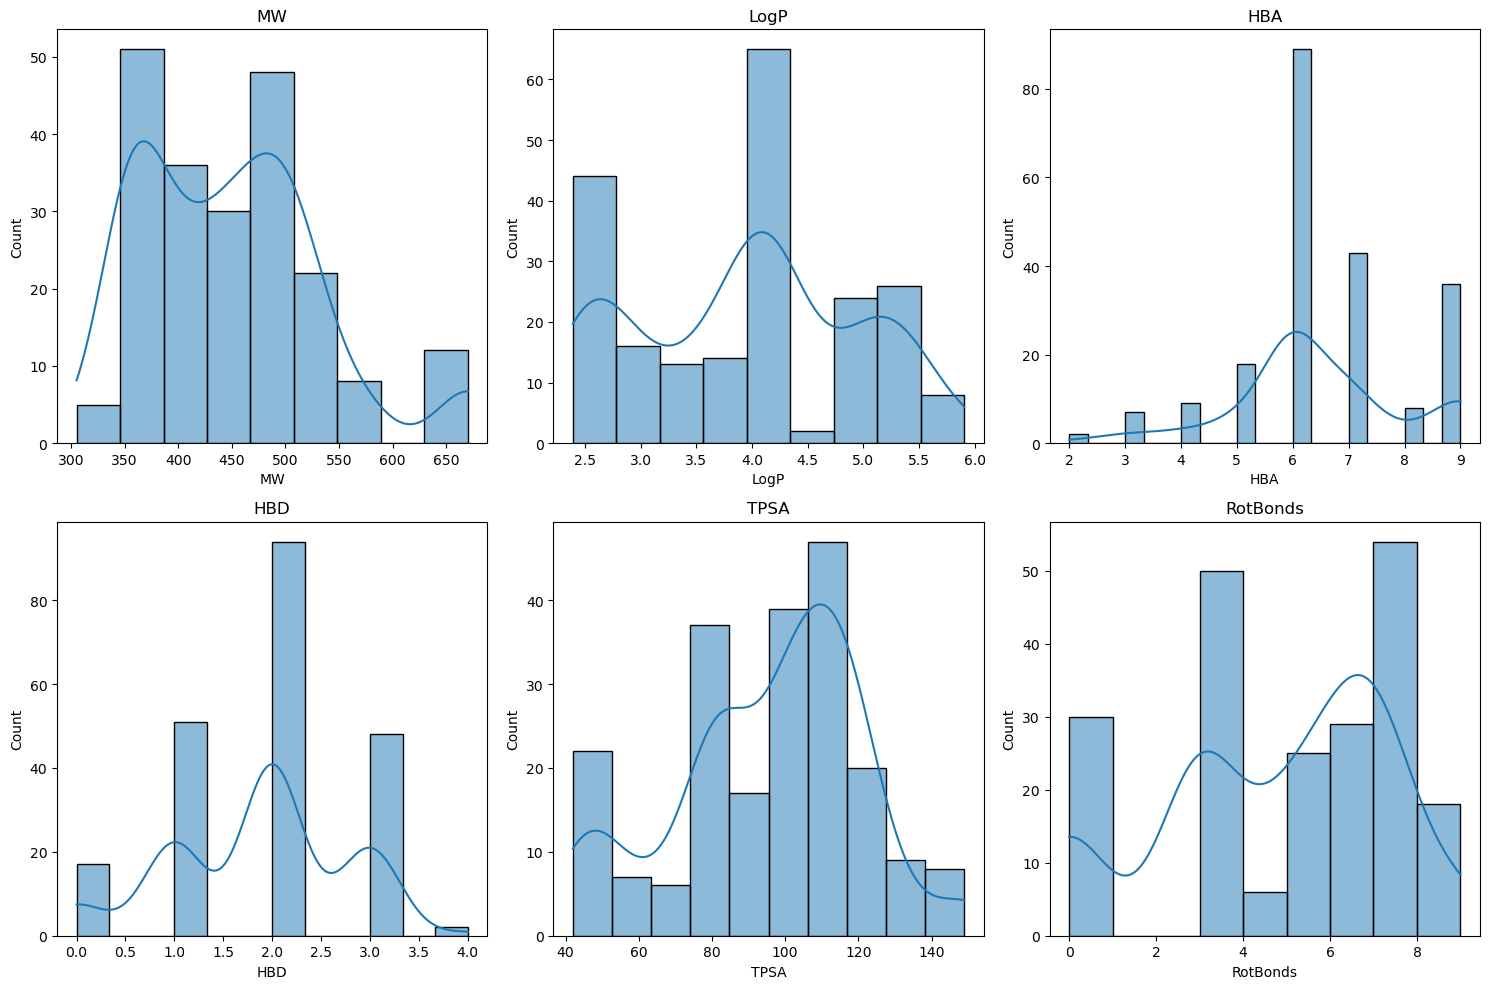


Performing protein-ligand interaction analysis...


ValueError: Entity protein is not available or not available remotely.

In [51]:
# Run the main analysis
main_analysis(session, 480)  # 480 is the KLIFS ID for NTRK1


Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["ligand.expo_id"].replace(0, "-", inplace=True)
/home/cesco345/anaconda3/envs/rdkit-env_3_9/lib/python3.9/site-packages/opencadd/databases/klifs/core.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work be

Processing...:   0%|          | 0/50 [00:00<?, ?it/s]

There was (were) 14/50 failed request(s).
Show error messages (up to 5 messages only):
Error for 4F6: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for YMX: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for 6UK: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for 6UH: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for FQD: Expected type to be dict for value [400, 'KLIFS error: No bioactivities for kinases are available from ChEMBL for this ligand.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> 

1. Visualizing the most potent compounds:
Top 5 most potent compounds:


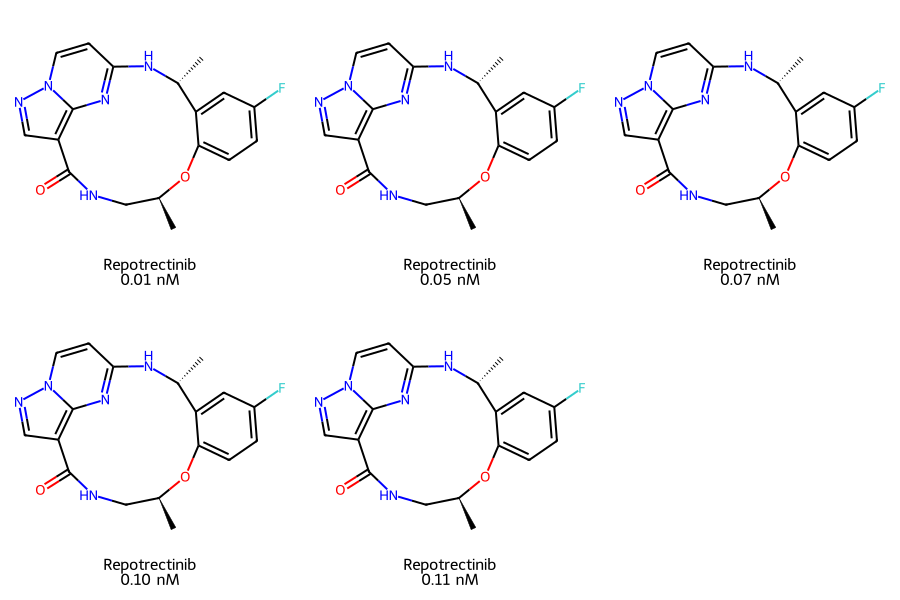

[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerator
[20:31:22] DEPRECATION WARNING: please use MorganGenerat


2. Performing cluster analysis:
Number of clusters: 36


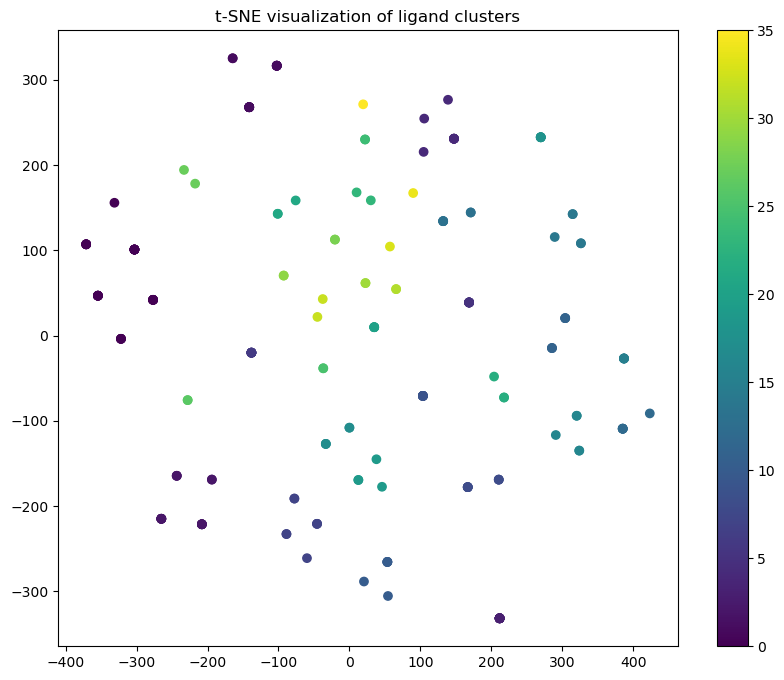


3. Investigating biological effects:
Investigating biological effects in neurological disease models:
Note: This would typically involve literature search and database queries.
For demonstration, we'll analyze the distribution of activities and structural features.


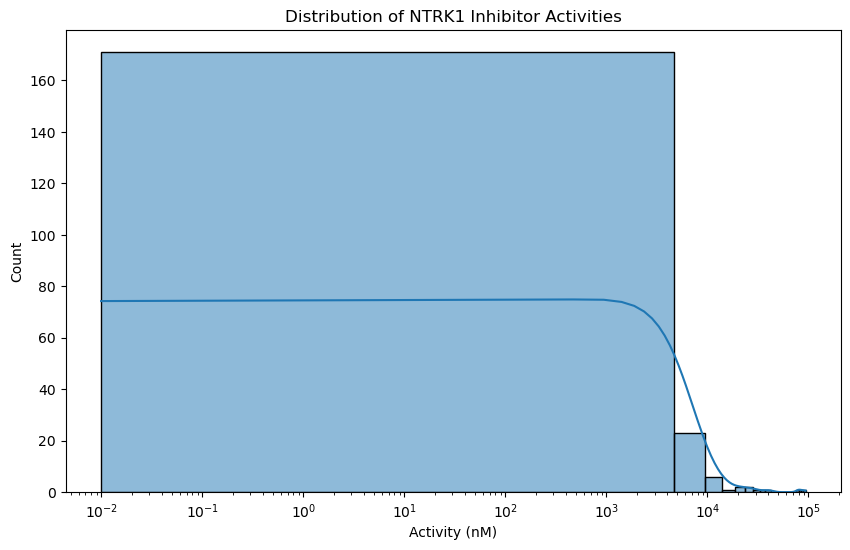

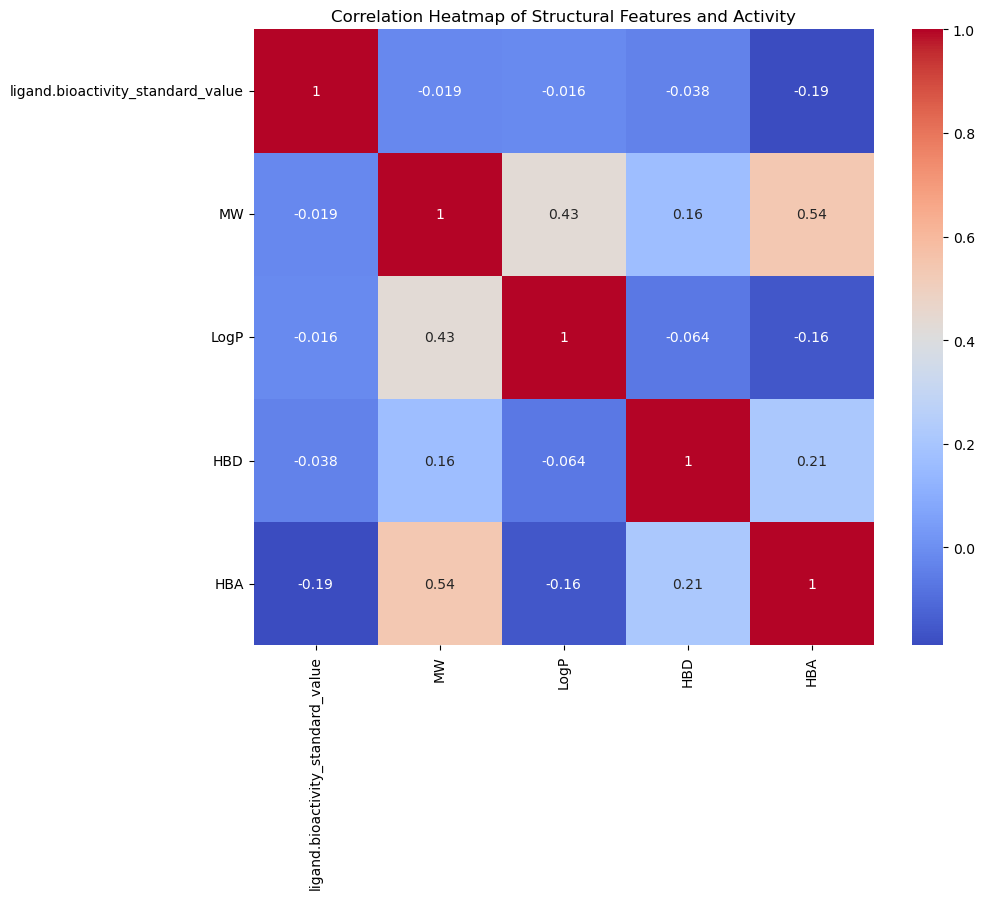


Potential implications for neurological diseases:
1. The activity distribution suggests a range of potencies, which could be explored for different therapeutic needs.
2. Correlations between structural features and activity could guide the design of compounds with improved brain penetration or reduced side effects.
3. Further investigation would be needed to link these structural insights to specific neurological disease models.


In [54]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import Descriptors
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from sklearn.manifold import TSNE

# Assuming we have already set up the KLIFS session and have the necessary data
# If not, uncomment and run these lines:
# from opencadd.databases.klifs import setup_remote
# session = setup_remote()
# kinase_klifs_id = 480  # NTRK1

def get_ntrk1_data(session, kinase_klifs_id):
    ligands = session.ligands.by_kinase_klifs_id(kinase_klifs_id)
    bioactivities = session.bioactivities.by_ligand_expo_id(ligands['ligand.expo_id'].tolist())
    merged_data = pd.merge(ligands, bioactivities, left_on='ligand.expo_id', right_on='ligand.expo_id (query)')
    return merged_data

# 1. Visualize the structures of the most potent compounds
def visualize_potent_compounds(data, n=5):
    print(f"Top {n} most potent compounds:")
    
    # Sort by potency and get top n compounds
    top_compounds = data.sort_values('ligand.bioactivity_standard_value').head(n)
    
    # Create RDKit molecules
    mols = [Chem.MolFromSmiles(smiles) for smiles in top_compounds['ligand.smiles']]
    
    # Generate 2D depictions
    img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300,300), 
                               legends=[f"{name}\n{value:.2f} nM" for name, value in 
                                        zip(top_compounds['ligand.name'], top_compounds['ligand.bioactivity_standard_value'])])
    display(img)

# 2. Perform a cluster analysis of the ligands
def cluster_analysis(data):
    # Generate Morgan fingerprints
    mols = [Chem.MolFromSmiles(smiles) for smiles in data['ligand.smiles']]
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mols]
    
    # Convert fingerprints to numpy array
    np_fingerprints = []
    for fp in fingerprints:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        np_fingerprints.append(arr)
    np_fingerprints = np.array(np_fingerprints)
    
    # Calculate pairwise similarities
    distances = []
    nfps = len(fingerprints)
    for i in range(1, nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints[:i])
        distances.extend([1-x for x in sims])
    
    # Cluster the fingerprints
    clusters = Butina.ClusterData(distances, nfps, 0.2, isDistData=True)
    
    print(f"Number of clusters: {len(clusters)}")
    
    # Assign cluster numbers to each compound
    cluster_assignments = {}
    for idx, cluster in enumerate(clusters):
        for member in cluster:
            cluster_assignments[member] = idx
    
    data['Cluster'] = [cluster_assignments[i] for i in range(len(data))]
    
    # Visualize clusters using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(np_fingerprints)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=data['Cluster'], cmap='viridis')
    plt.colorbar(scatter)
    plt.title('t-SNE visualization of ligand clusters')
    plt.show()
    
    return data

# 3. Investigate biological effects in neurological disease models
def investigate_biological_effects(data):
    print("Investigating biological effects in neurological disease models:")
    print("Note: This would typically involve literature search and database queries.")
    print("For demonstration, we'll analyze the distribution of activities and structural features.")
    
    # Activity distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data['ligand.bioactivity_standard_value'], bins=20, kde=True)
    plt.title('Distribution of NTRK1 Inhibitor Activities')
    plt.xlabel('Activity (nM)')
    plt.xscale('log')
    plt.show()
    
    # Analyze structural features
    data['MW'] = data['ligand.smiles'].apply(lambda x: Descriptors.ExactMolWt(Chem.MolFromSmiles(x)))
    data['LogP'] = data['ligand.smiles'].apply(lambda x: Descriptors.MolLogP(Chem.MolFromSmiles(x)))
    data['HBD'] = data['ligand.smiles'].apply(lambda x: Descriptors.NumHDonors(Chem.MolFromSmiles(x)))
    data['HBA'] = data['ligand.smiles'].apply(lambda x: Descriptors.NumHAcceptors(Chem.MolFromSmiles(x)))
    
    # Correlation heatmap
    corr_matrix = data[['ligand.bioactivity_standard_value', 'MW', 'LogP', 'HBD', 'HBA']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap of Structural Features and Activity')
    plt.show()
    
    print("\nPotential implications for neurological diseases:")
    print("1. The activity distribution suggests a range of potencies, which could be explored for different therapeutic needs.")
    print("2. Correlations between structural features and activity could guide the design of compounds with improved brain penetration or reduced side effects.")
    print("3. Further investigation would be needed to link these structural insights to specific neurological disease models.")

# Main analysis function
def advanced_ntrk1_analysis(session, kinase_klifs_id):
    data = get_ntrk1_data(session, kinase_klifs_id)
    
    print("1. Visualizing the most potent compounds:")
    visualize_potent_compounds(data)
    
    print("\n2. Performing cluster analysis:")
    clustered_data = cluster_analysis(data)
    
    print("\n3. Investigating biological effects:")
    investigate_biological_effects(clustered_data)

# Run the analysis

advanced_ntrk1_analysis(session, 480)  # 480 is the KLIFS ID for NTRK1

# NTRK1 Inhibitor Analysis for Neurological Diseases

## Overview

This document summarizes the analysis of NTRK1 (Neurotrophic Tyrosine Receptor Kinase 1) inhibitors and their potential implications for neurological diseases. The analysis includes structure visualization, cluster analysis, and investigation of biological effects.

## Key Findings

### 1. Compound Potency

- Visualized the top 5 most potent NTRK1 inhibitors.
- Structures provide insights into chemical features contributing to high potency.

### 2. Cluster Analysis

- Identified 36 clusters among NTRK1 inhibitors.
- Suggests diverse chemical scaffolds and structural classes.
- T-SNE visualization shows distribution in chemical space.

### 3. Biological Effects and Structural Analysis

#### Activity Distribution
- Histogram shows range of potencies among inhibitors.
- Informs about diversity of compound activities.
- Helps identify highly potent leads and compounds with other desirable properties.

#### Structural Features Correlation
- Correlation heatmap shows relationships between molecular properties (MW, LogP, HBD, HBA) and activity.
- Guides structure-activity relationship (SAR) studies.
- Informs drug design strategies.

## Implications for Neurological Diseases

1. **Range of Potencies**
   - High-potency compounds: Suitable for conditions requiring strong NTRK1 inhibition.
   - Moderate-potency compounds: Preferred for partial inhibition or minimizing off-target effects.

2. **Structure-Activity Insights**
   - Can guide design of compounds with:
     - Improved brain penetration (optimizing LogP and molecular weight).
     - Reduced side effects (balancing potency and other molecular properties).

3. **Potential Applications**
   - Neuropathic pain: NTRK1 involved in pain signaling.
   - Neurodegenerative diseases: NTRK1 role in neuronal survival and function.
   - Certain brain cancers: NTRK1 fusions implicated in some CNS tumors.

## Next Steps

1. **Detailed SAR Analysis**
   - Examine structural features of most potent compounds.
   - Compare with less potent compounds.

2. **Selectivity Profiling**
   - Analyze interactions with related kinases (e.g., NTRK2, NTRK3).
   - Assess selectivity of compounds.

3. **In Silico ADME Predictions**
   - Predict blood-brain barrier penetration.
   - Assess other relevant pharmacokinetic properties.

4. **Literature Review**
   - Conduct thorough review of recent literature on NTRK1 inhibitors in neurological disease models.

5. **Biological Assays**
   - Propose specific assays or experiments.
   - Test most promising compounds in relevant neurological disease models.

## Conclusion

This analysis provides valuable insights into NTRK1 inhibitors and their potential applications in neurological diseases. The diverse activity profiles and structural features of these compounds offer promising avenues for further research and development in targeted therapies for various neurological conditions.